# import

In [2]:
import time
import glob
import datetime
import random
import pickle
import numpy as np
import shutil
import os
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1) # (A)
import keras.optimizers  # (B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from decimal import *
from keras.layers.recurrent import SimpleRNN, LSTM
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score  
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, accuracy_score,roc_curve, roc_auc_score
from graphviz import *

# funcs

In [3]:
def xgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {'objective':'binary:logistic', 
                  'n_estimators':16,
                  'use_label_encoder':False,
                 'max_depth':4,
                  'random_state':100,
                 }
    xgb_model = xgb.XGBClassifier(**param_dist)
    hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    y_proba_train = xgb_model.predict_proba(x_train)[:,1]
    y_proba = xgb_model.predict_proba(x_test)[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    xgb.plot_importance(xgb_model) 
    return xgb_model

def eval_proba(x_test, y_test, xgb_model):
    predict_proba = xgb_model.predict_proba(x_test.astype(float))
    df = pd.DataFrame(columns = ['alpha','score','Up precision','Down precision','Up recall','Down recall','num'])
    j=0
    
    
    for alpha in [0.70,0.8,0.9]:
        acc_dict = {'TU':0,'FU':0,'TD':0,'FD':0}
        for i in range(len(predict_proba)):
            row = predict_proba[i]
            label = np.argmax(row)
            proba = row[label]
            if proba > alpha:
                if y_test[i]==label:
                    if label==0:
                        acc_dict['TD'] += 1
                    else:
                        acc_dict['TU'] += 1
                else:
                    if label==0:
                        acc_dict['FD'] += 1
                    else:
                        acc_dict['FU'] += 1

        try:
            denom = 0
            for idx, key in enumerate(acc_dict):
                denom += acc_dict[key]
            if denom==0:continue


            TU = acc_dict['TU']
            FU = acc_dict['FU']
            TD = acc_dict['TD']
            FD = acc_dict['FD']
            score = (TU + TD)/(denom)
            prec_u = TU/(TU + FU)
            prec_d = TD/(TD + FD)
            recall_u = TU/(TU + FD)
            recall_d = TD/(TD + FU)
            col_list = [alpha,score,prec_u,prec_d,recall_u,recall_d,denom]
            df.loc[j] = col_list
            j+=1
        except:
            print("division by zero.")
    return df

# classes

In [18]:
class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)

class MakeTrainData():
    
    
    def __init__(self, df_con, test_rate=0.8, questions_index = [], is_bit_search=False,is_category=True,ma_short=5,ma_long=25):
        self.df_con = df_con
        self.test_rate = test_rate
        self.questions_index = questions_index
        self.is_bit_search = is_bit_search
        self.is_category = is_category
        self.ma_short = ma_short
        self.ma_long = ma_long
        
        
    def labeling(self):
        if self.is_category:
            up=1
            down=0
        else:
            up=[0,1]
            down=[1,0]
        
        
        return up,down
    
    
    def append_onehotlist(self, one_hot_list, questions):
        for i in range(len(questions)):
            if questions[i]:
                one_hot_list.append(1)
            else:
                one_hot_list.append(0)
                
                
    def add_ma(self):
        df_process = self.df_con.copy()
        df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
        df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        return df_process
                
    
    def make_question_column(self):
        column_questions = [
            
            'dawp_5',
            'dawp_4',
            'dawp_3',
            'dawp_2',
            'dawp_1',
            'nikkeip_5',
            'nikkeip_4',
            'nikkeip_3',
            'nikkeip_2',
            'nikkeip_1',
            'diff_rate',
            'nikkei_volumep',
            'ma_short',
            'ma_long'
        
        ]
        return column_questions
        
        
                
                
    
    def make_data(self):
        selected_column = []
        if self.is_bit_search:
            for i in self.questions_index:
                selected_column.append(self.column[i])
            dfx = pd.DataFrame(columns = selected_column)
        else:
            dfx = pd.DataFrame(columns = self.make_question_column())
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        for i in range(self.ma_long,len(self.df_con)-1):
            dawp_5 = self.df_con['dclose'].iloc[i-4]
            dawp_4 = self.df_con['dclose'].iloc[i-3]
            dawp_3 = self.df_con['dclose'].iloc[i-2]
            dawp_2 = self.df_con['dclose'].iloc[i-1]
            dawp_1 = self.df_con['dclose'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-4]
            nikkeip_4 = df_tpx_p.iloc[i-3]
            nikkeip_3 = df_tpx_p.iloc[i-2]
            nikkeip_2 = df_tpx_p.iloc[i-1]
            nikkeip_1 = df_tpx_p.iloc[i]
            
            diff_high_low = self.df_con['high'].iloc[i] - \
                            self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])\
            /self.df_con['volume'].iloc[i-1]
            df_ma = self.add_ma()
            ma_short = df_ma['ma_short'].iloc[i]
            ma_long  = df_ma['ma_long'].iloc[i]
            
            
    # ---------------Question----------------
            questions = [
                dawp_5,
                dawp_4,
                dawp_3,
                dawp_2,
                dawp_1,
                nikkeip_5,
                nikkeip_4,
                nikkeip_3,
                nikkeip_2,
                nikkeip_1,
                diff_rate,
                nikkei_volumep,
                ma_short,
                ma_long
            ]
        
            
            if self.is_bit_search:
                selected_questions = []
                for j in self.questions_index:
                    selected_questions.append(questions[j])
                    
            else:
                selected_questions = questions


            dfx.loc[self.df_con.index[i]] = selected_questions
            tommorow_close = self.df_con['close'].iloc[i+1]
            today_close    = self.df_con['close'].iloc[i]
            if tommorow_close>today_close:
                df_ans.append(up)
            else:
                df_ans.append(down)
                
        x_train = dfx.iloc[:int(len(dfx)*self.test_rate)]
        y_train = df_ans[:int(len(dfx)*self.test_rate)]
        x_test  = dfx.iloc[int(len(dfx)*self.test_rate):]
        y_test  = df_ans[int(len(dfx)*self.test_rate):]
        
        
        return x_train, y_train, x_test, y_test
    
class PlotTrade():
    
    
    def __init__(self, df_chart):
        self.df_chart = df_chart
        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.ax.plot(self.df_chart['close'])
        
        
    def add_span(self, start_time,end_time):
        self.ax.axvspan(start_time, end_time, color="gray", alpha=0.3)
        
    
    def add_plot(self, df_plot):
        self.ax.plot(df_plot)
        
        
    def show(self):
        self.ax.grid()
        labels = self.ax.get_xticklabels()
        plt.setp(labels, rotation=15, fontsize=12)
        plt.show()    
        
class Simulation():
    
    
    def __init__(self, xgb_model, path_, alpha=0.70):
        self.xgb_model = xgb_model
        self.path_ = path_
        self.alpha = alpha
        self.df_con = self.make_df_con().iloc[-250:]
        
    
    def make_df_con(self):
        path_daw_sim = '/Users/rince/Desktop/StockPriceData/DAW/*.csv'
        file =  glob.glob(path_daw_sim)
        path_daw = sorted(file)[-1]
        df_tpx = DataFramePreProcessing(self.path_).load_df()
        df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
        daw_p = df_daw.pct_change()
        df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
        df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
        return df_tmp
    
    
    def make_check_data(self):
        x_check, y_check, x_dummy, y_dummy = MakeTrainData(self.df_con,test_rate=1.0).make_data()
        return x_check, y_check
    
    
    def eval_proba(self, x_test, y_test):
        predict_proba = self.xgb_model.predict_proba(x_test.astype(float))
        df = pd.DataFrame(columns = ['score','Up precision','Down precision','Up recall','Down recall','num'])
        j=0
        acc_dict = {'TU':0,'FU':0,'TD':0,'FD':0}
        
        
        for i in range(len(predict_proba)):
            row = predict_proba[i]
            label = np.argmax(row)
            proba = row[label]
            if proba > self.alpha:
                if y_test[i]==label:
                    if label==0:
                        acc_dict['TD'] += 1
                    else:
                        acc_dict['TU'] += 1
                else:
                    if label==0:
                        acc_dict['FD'] += 1
                    else:
                        acc_dict['FU'] += 1


        denom = 0
        for idx, key in enumerate(acc_dict):
            denom += acc_dict[key]
        
        try:
            TU = acc_dict['TU']
            FU = acc_dict['FU']
            TD = acc_dict['TD']
            FD = acc_dict['FD']
            score = (TU + TD)/(denom)
            prec_u = TU/(TU + FU)
            prec_d = TD/(TD + FD)
            recall_u = TU/(TU + FD)
            recall_d = TD/(TD + FU)
            col_list = [score,prec_u,prec_d,recall_u,recall_d,denom]
            df.loc[j] = col_list
            j+=1
            return df
        except:
            print("division by zero")
         
        
    def simulate(self, x_check, y_check, strategy='normal'):
        length = len(x_check)
        predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
        is_bought = False
        index_buy = 0
        index_sell = 0
        prf = 0
        trade_count = 0
        pl = PlotTrade(self.df_con)
        prf_list = []

        
        for i in range(length-1):
            
            row = predict_proba[i]
            label = np.argmax(row)
            prob = row[label]
#             label==0 -> down
#             label==1 -> up
            
            if strategy=='normal':
            
                if not is_bought:
    #                 下がって買い
                    if label==0 and prob>self.alpha:
                        index_buy = self.df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 上がって売り
                    if label==1 and prob>self.alpha:
                        index_sell = self.df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
            elif strategy=='reverse':
                
                if not is_bought:
    #                 上がって買い
                    if label==1 and prob>self.alpha:
                        index_buy = self.df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 下がって売り
                    if label==0 and prob>self.alpha:
                        index_sell = self.df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
            else:
                print("No such strategy.")
                return 
                  
        
        if is_bought:
            index_sell = self.df_con['close'].loc[x_check.index[-1]] 
            prf += index_sell - index_buy
            prf_list.append(index_sell - index_buy)
            end_time = x_check.index[-1]
            trade_count+=1
            pl.add_span(start_time,end_time)
            
    
        prf_array = np.array(prf_list)
        try:
            print("Total profit :{}".format(prf))
            print("Trade count  :{}".format(trade_count))
            print("Max profit   :{}".format(prf_array.max()))
            print("Min profit   :{}".format(prf_array.min()))
            print("Mean profit  :{}".format(prf_array.mean()))
            pl.show()
        except:
            print("no trade")
                    
    
    def show_result(self, strategy='normal'):
        x_check, y_check = self.make_check_data()
        df = self.eval_proba(x_check,y_check)
        print(df)
        print("")
        self.simulate(x_check,y_check,strategy)
        

# path_

In [5]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_toyota = '/Users/rince/Desktop/StockPriceData/Stock_index/07Toyota.csv'
path_bear = '/Users/rince/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

# load df

In [6]:
df_tpx = DataFramePreProcessing(path_tpx).load_df()
df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
daw_p = df_daw.pct_change()
df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)


# make data 

In [7]:
x_train, y_train, x_test, y_test = MakeTrainData(df_tmp).make_data()


# Data format

In [8]:
x_train.head()

,dawp_5,dawp_4,dawp_3,dawp_2,dawp_1,nikkeip_5,nikkeip_4,nikkeip_3,nikkeip_2,nikkeip_1,diff_rate,nikkei_volumep,ma_short,ma_long
2011-08-11,0.005352,-0.055464,0.039771,-0.046249,0.039494,-0.032491,-0.019900,-0.019036,0.009056,-0.005128,0.015464,-0.361288,784.2,845.28
2011-08-12,-0.055464,0.039771,-0.046249,0.039494,0.011281,-0.019900,-0.019036,0.009056,-0.005128,-0.005155,0.019430,-0.580390,777.8,841.08
2011-08-15,0.039771,-0.046249,0.039494,0.011281,0.018979,-0.019036,0.009056,-0.005128,-0.005155,0.010363,0.011538,-0.097242,776.2,837.12
2011-08-16,-0.046249,0.039494,0.011281,0.018979,-0.006703,0.009056,-0.005128,-0.005155,0.010363,0.005128,0.010204,-0.029312,778.4,833.44
2011-08-17,0.039494,0.011281,0.018979,-0.006703,0.000375,-0.005128,-0.005155,0.010363,0.005128,-0.003827,0.010243,-0.312006,778.6,830.24


In [10]:
type(x_train), type(y_train)

(pandas.core.frame.DataFrame, list)

# make model

AUC train: 0.860577203982112
AUC test : 0.6767285722020684
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       219
           1       0.65      0.65      0.65       253

    accuracy                           0.63       472
   macro avg       0.63      0.63      0.63       472
weighted avg       0.63      0.63      0.63       472



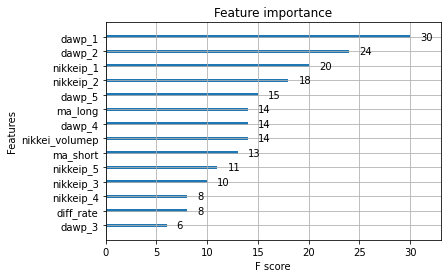

In [12]:
xgb_model = xgb_pred(x_train, y_train, x_test, y_test)

# simulation

In [13]:
path_daw_sim = '/Users/rince/Desktop/StockPriceData/DAW/*.csv'
path_tpx_sim = '/Users/rince/Desktop/StockPriceData/TOPIX/*.csv'
file =  glob.glob(path_tpx_sim)
path_tpx_sim = sorted(file)[-1]

      score  Up precision  Down precision  Up recall  Down recall   num
0  0.710145         0.725        0.689655   0.763158     0.645161  69.0

Total profit :261.0
Trade count  :22
Max profit   :134.0
Min profit   :-66.0
Mean profit  :11.863636363636363


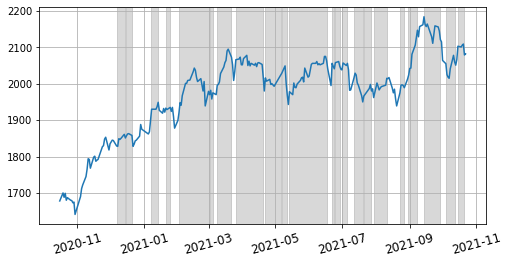

In [16]:
sl = Simulation(xgb_model,path_ = path_tpx_sim, alpha=0.7)
sl.show_result(strategy='reverse')

# Show tree structure

In [17]:
xgb.to_graphviz(xgb_model)